# Synthesizing Benchmarks for Predictive Modeling

[Chris Cummins](http://chriscummins.cc/),
[Pavlos Petoumenos](http://homepages.inf.ed.ac.uk/ppetoume/),
[Zheng Wang](http://www.lancaster.ac.uk/staff/wangz3/),
[Hugh Leather](http://homepages.inf.ed.ac.uk/hleather/).

### How to use this document

1. Click on the first code block.
1. Press `Ctrl+Enter` to run the code.
1. Once completed, the code will self-test. If the test passes it will display:
<div style="background-color:#5cb85c; color:#fff; text-align:center; border-radius:10px;">
  <h1 style="padding:.5em; font-weight:400;">☑ Complete</h1>
</div>
If the test fails it will display:
<div style="background-color:#d9534f; color:#fff; text-align:center; border-radius:10px;">
  <h1 style="padding:.5em; font-weight:400;">☒ Failed</h1>
</div>
1. Evaluate the output and proceed to the next code block.

Alternatively, to run all of the code blocks automatically in sequence, select from the menu "Kernel" > "Restart and Run All".

For further information on using Jupyter notebooks, see the [official documentation](https://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Notebook%20Basics.html).

### Useful links
* ["Interactive Paper"](/notebooks/Paper.ipynb) is a comprehensive version of this evaluation for those wishing to evaluate every aspect of the paper.
* Install this artifact on your own hardware: http://chriscummins.cc/cgo17/
* Online version of the OpenCL Turing Test: http://humanorrobot.uk/game/?g=opencl&m=nitt
* CLgen source code: https://github.com/ChrisCummins/clgen/
* CLgen API documentation: http://chriscummins.cc/clgen/api/

In [75]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run lib/preamble.py

from IPython.core.display import HTML
HTML("""<style>
/* hide index column in Pandas Data Frames */
table.dataframe thead th:first-child { display: none; }
table.dataframe tbody th { display: none; }

/* tweak text size */
div.text_cell_render { font-size: 1.3em; line-height: 1.4em; }
</style>""")
complete(msg="Initial setup complete")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


         There may be incompatabilities.


## Experimental Setup

This artifact must be evaluated on a CPU-GPU heterogeneous system. Details about this system:

In [45]:
import clgen.clutil
clgen.clutil.platform_info()

complete(can_reproduce_experiments(), "Artifact is running on suitable hardware")

Platform:   Linux
Memory:     15954 MB

Device:     CPU Intel(R) Core(TM) i7-4770 CPU @ 3.40GHz
Compute #.: 8
Frequency:  3400 HZ
Memory:     15954 MB
Driver:     1.2.0.25

Device:     GPU GeForce GTX TITAN
Compute #.: 14
Frequency:  980 HZ
Memory:     6080 MB
Driver:     367.57


# Generating OpenCL using Deep Learning
Load our pre-trained Neural Network, generate new samples, validate samples.

In [46]:
print("The model used in the paper (pre-trained):")
model = clgen.model.from_tar("../data/clgen-github-model-2016-nov-2048x3.tar.bz2")
print(model)
complete(model.hash == "f2fb3ad753896d54fe284c138eaa703db3518bbb",
         "Load pre-trained neural network")

The model used in the paper (pre-trained):
f2fb3ad753896d54fe284c138eaa703db3518bbb: {
  "max_epochs": 50,
  "model_type": "lstm",
  "num_layers": 3,
  "rnn_size": 2048
}


In [15]:
# sample model
import clgen.sampler
import clgen.dbutil
argspec = ['__global float*', '__global float*', '__global float*', 'const int']
sampler = clgen.sampler.from_json({
        "kernels": { 
            "args": argspec,
            "max_length": 500,
        },
        "sampler": {
            "batch_size": 20,
            "max_kernels": 5,
        }
    })

print("Sample from the model used in the paper:\n")
print("Seed text:", clgen.sampler.serialize_argspec(argspec))
sampler.cache(model).empty()
sampler.sample(model)

num_good_kernels = clgen.dbutil.num_good_kernels(sampler.cache(model)["kernels.db"])
complete(num_good_kernels >= 5,
         "Generated {} new OpenCL kernels".format(num_good_kernels))

Sample from the model used in the paper:

Seed text: __kernel void A(__global float* a, __global float* b, __global float* c, const int d) {


/* === SAMPLE 1 === */	
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);
  int f = c % b;
  int g = e << (e - 1);
  return b;
}

/* === SAMPLE 2 === */	
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < 2) {
    g[e] = 0.0;
  }
}

/* === SAMPLE 3 === */	
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < c + 2 * e) {
    a[e + b] = b[e];
  }
}

/* === SAMPLE 4 === */	
__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < d * c) {
    *a = a + b;
  }
}

/* === SAMPLE 5 === */	
__kernel void A(__global float* a, __global float* b, __global float* c, const int 

In [55]:
db = clgen.dbutil.connect(sampler.cache(model)["kernels.db"])
c = db.cursor()

c.execute("""SELECT Contents FROM PreprocessedFiles WHERE status=0""")
for i, row in enumerate(c.fetchall()):
    kernel = row[0]
    print("\nKernel ", i+1, ":\n", sep="")
    print(kernel)

c.close()
db.close()
complete(msg="Display generated OpenCL kernels")


Kernel 1:

__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < c) {
    a[e] += b[e];
  }
}

Kernel 2:

__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  c[e] = a[e] + b[e];
}

Kernel 3:

__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);
  int f = get_global_id(1);
  int g = e + d - f;
  int h = f + c;

  for (int i = c; i < e; i++) {
    b[e] = a[h] - b[g];
  }
}

Kernel 4:

__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < c + 1 && e + 2 < d) {
    c[e] = 0.0f;
  }
  barrier(1);

  if (e < d) {
    e = a[e];
    b[e] = a[e] + b[e];
  }
}

Kernel 5:

__kernel void A(__global float* a, __global float* b, __global float* c, const int d) {
  int e = get_global_id(0);

  if (e < d) {
    c[e] = a[e] * b[e]

# Benchmark suite performance results
Reproduce benchmark experiments using 1 of 7 benchmark suites from paper:

In [49]:
print("runing ... (this will take a few minuts)")
try:
    !rm -fv ../data/benchmarks/*.csv
    !cd benchmarks && ./mkdata
    data = pd.read_csv("../data/benchmarks/training.csv")
    complete(len(data) == 17, "Produced new performance results for benchmarks")
except:
    complete(False, "Did not produce new performance results for benchmarks")

runing ... (estimated runtime: 10 minutes)
Build amd-app-sdk-3.0 for CPU
ITERATION 1 of 10 amd-app-sdk-3.0 CPU ...
amd-app-sdk-3.0 BinomialOption ... ok
amd-app-sdk-3.0 BitonicSort ... ok
amd-app-sdk-3.0 BlackScholes ... ok
amd-app-sdk-3.0 FastWalshTransform ... ok
amd-app-sdk-3.0 FloydWarshall ... ok
amd-app-sdk-3.0 MatrixMulImage ... ok
amd-app-sdk-3.0 MatrixMultiplication ... ok
amd-app-sdk-3.0 MatrixTranspose ... ok
amd-app-sdk-3.0 MonteCarloAsian ... ok
amd-app-sdk-3.0 NBody ... ok
amd-app-sdk-3.0 PrefixSum ... ok
amd-app-sdk-3.0 Reduction ... ok
amd-app-sdk-3.0 ScanLargeArrays ... ok
amd-app-sdk-3.0 SimpleConvolution ... ok
amd-app-sdk-3.0 SobelFilter ... ok
ITERATION 2 of 10 amd-app-sdk-3.0 CPU ...
amd-app-sdk-3.0 BinomialOption ... ok
amd-app-sdk-3.0 BitonicSort ... ok
amd-app-sdk-3.0 BlackScholes ... ok
amd-app-sdk-3.0 FastWalshTransform ... ok
amd-app-sdk-3.0 FloydWarshall ... ok
amd-app-sdk-3.0 MatrixMulImage ... ok
amd-app-sdk-3.0 MatrixMultiplication ... ok
amd-app-sdk-3.0

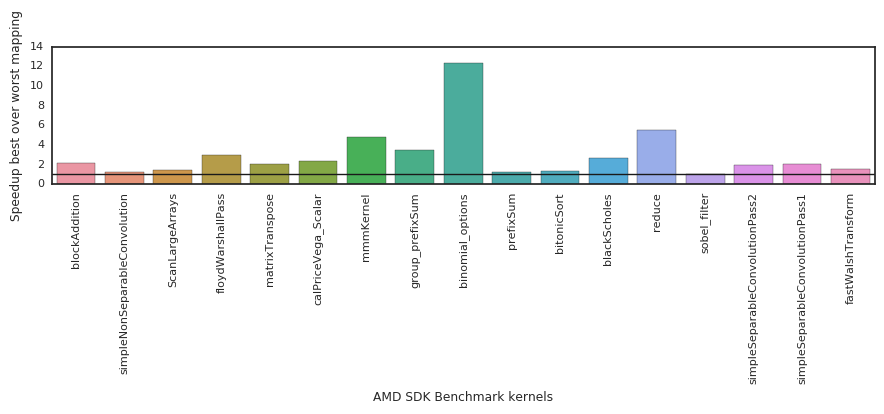

In [63]:
try:
    data = pd.read_csv("../data/benchmarks/training.csv")
    ax = sns.barplot(x="benchmark", y="speedup", data=data)
    plt.ylabel("Speedup best over worst mapping")
    plt.xlabel("AMD SDK Benchmark kernels")
    plt.axhline(y=1, color="k", lw=1)  # speedup line
    plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
    ax.set_xticklabels([shortbenchmark(x.get_text()) for x in ax.get_xticklabels()])
    viz.finalise(figsize=(9,4))
    complete(len(set(data["benchmark"])) == 17, "New performance numbers from 17 AMD kernels")
except:
    complete(False, "No benchmark results to analyze")

# CLgen kernel performance results
Using 1% of CLgen kernels used in the paper:

In [52]:
print("runing ... (this will take a few minuts)")
try:
    !rm -fv ../data/clgen-10/*.csv
    !cd bin && ./mkdata
    complete(msg="Generated new performance results for CLgen benchmarks")
except:
    complete(False, "Did not produce new performance results for CLgen benchmarks")

runing ... (estimated runtime: 10 minutes)
removed '../data/clgen-10/cpu-errors.csv'
removed '../data/clgen-10/cpu.csv'
building job list for ../../data/clgen-10/cpu.csv ... 149 jobs
16-11-18 10:10:48 whz5 job [1/150] 0.67% ... cpu 256 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-18 10:10:48 whz5 job [2/150] 1.33% ... cpu 512 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-18 10:10:49 whz5 job [3/150] 2.00% ... cpu 1024 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-18 10:10:49 whz5 job [4/150] 2.67% ... cpu 2048 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-18 10:10:50 whz5 job [5/150] 3.33% ... cpu 4096 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-18 10:10:50 whz5 job [6/150] 4.00% ... cpu 8192 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-18 10:10:50 whz5 job [7/150] 4.67% ... cpu 16384 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-18 10:10:51 whz5 job [8/150] 5.33% ... cpu 65536 019a0128d0c5fe33678335a7cf7050cad56bbae0.cl
16-11-18 10:10:51 whz5 job [9/150

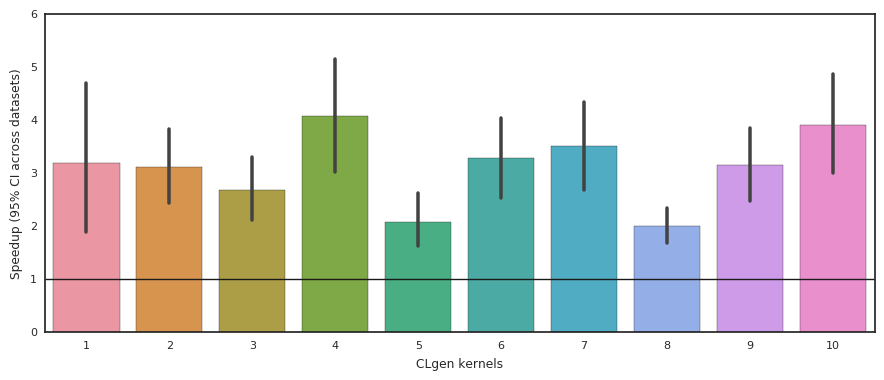

In [62]:
try:
    data = pd.read_csv("../data/clgen-10/training.csv")   
    ax = sns.barplot(x="benchmark", y="speedup", ci=95, data=data)
    plt.ylabel("Speedup (95% CI across datasets)")
    plt.xlabel("CLgen kernels")
    plt.axhline(y=1, color="k", lw=1)  # speedup line
    ax.set_xticklabels(range(1, len(data) + 1))
    viz.finalise(figsize=(9,4))
    complete(len(set(data["benchmark"])) == 10, "New performance numbers from 10 CLgen kernels")
except:
    complete(False, "No CLgen benchmark results to analyze")

# Predictive Model performance with CLgen benchmarks 

  #. benchmarks:                   256 kernels, 680 observations
  #. synthetic:                    1000 kernels, 15919 observations

  ZeroR device:                    CPU

  Speedup of Grewe et al.:         1.26 x
  Speedup w. CLgen:                1.57 x


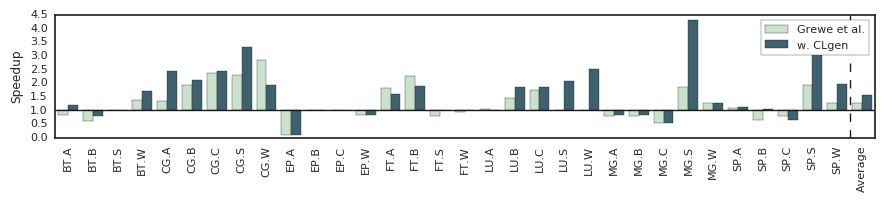

  #. benchmarks:                   256 kernels, 680 observations
  #. synthetic:                    1000 kernels, 15919 observations

  ZeroR device:                    GPU

  Speedup of Grewe et al.:         2.50 x
  Speedup w. CLgen:                3.26 x


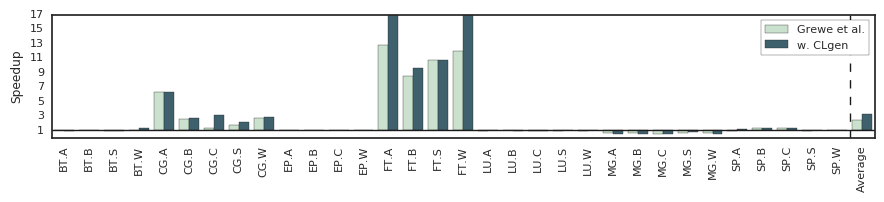

  #. benchmarks:                   17 kernels, 17 observations
  #. synthetic:                    10 kernels, 138 observations

  ZeroR device:                    CPU

  Speedup of Grewe et al.:         0.98 x
  Speedup w. CLgen:                1.35 x


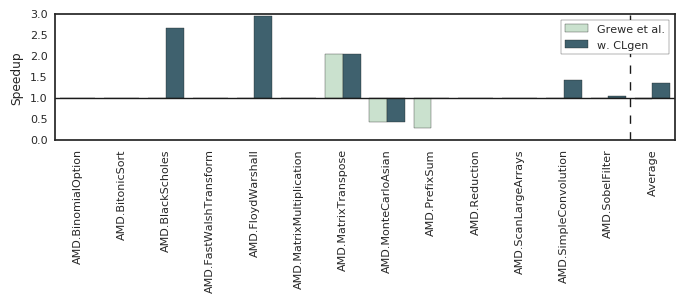

In [76]:
def speedups_with_clgen(platform):
    # datasets: B - benchmarks, S - synthetics, BS - benchmarks + synthetics:
    B = pd.read_csv("../data/{platform}-benchmarks.csv".format(platform=platform))
    B["group"] = ["B"] * len(B)

    S = pd.read_csv("../data/{platform}-clgen.csv".format(platform=platform))
    S["group"] = ["S"] * len(S)

    BS = pd.concat((B, S))

    # find the ZeroR. This is the device which is most frequently optimal
    Bmask = B[B["benchmark"].str.contains("npb-3.3-")]
    zeror = Counter(Bmask["oracle"]).most_common(1)[0][0]
    zeror_runtime = "runtime_" + zeror.lower()

    # get the names of the benchmarks, in the form: $suite-$version-$benchmark
    benchmark_names = sorted(set([
        re.match(r"^([^0-9]+-[0-9\.]+-[^-]+)-", b).group(1)
        for b in B["benchmark"] if b.startswith("npb-")
    ]))

    B_out, BS_out = [], []
    for benchmark in benchmark_names:
        clf = cgo13.model()
        features = get_cgo13_features
        # cross validate on baseline
        B_out += cgo13.leave_one_benchmark_out(clf, features, B, benchmark)
        # reset model
        clf = cgo13.model()
        # repeate cross-validation with synthetic kernels
        BS_out += cgo13.leave_one_benchmark_out(clf, features, BS, benchmark)

    # create results frame
    R_out = []
    for b, bs in zip(B_out, BS_out):
        # get runtimes of device using predicted device
        b_p_runtime = b["runtime_" + b["p"].lower()]
        bs_p_runtime = bs["runtime_" + bs["p"].lower()]

        # speedup is the ratio of runtime using the predicted device
        # over runtime using ZeroR device
        b["p_speedup"] = b_p_runtime / b[zeror_runtime]
        bs["p_speedup"] = bs_p_runtime / bs[zeror_runtime]

        # get the group label, in the form $benchmark.$dataset
        group = re.sub(r"[^-]+-[0-9\.]+-([^-]+)-.+", r"\1",
                       b["benchmark"]) + "." + b["dataset"]
        b["group"] = group
        bs["group"] = group

        # set the training data type
        b["training"] = "Grewe et al."
        bs["training"] = "w. CLgen"

        R_out.append(b)
        R_out.append(bs)

    R = pd.DataFrame(R_out)

    b_mask = R["training"] == "Grewe et al."
    bs_mask = R["training"] == "w. CLgen"

    B_speedup = labmath.mean(R[b_mask].groupby(["group"])["p_speedup"].mean())
    BS_speedup = labmath.mean(R[bs_mask].groupby(["group"])["p_speedup"].mean())

    header("Results from the paper on", platform.upper())
    print("  #. benchmarks:                  ",
          len(set(B["benchmark"])), "kernels,", len(B), "observations")
    print("  #. synthetic:                   ",
          len(set(S["benchmark"])), "kernels,", len(S), "observations")
    print()
    print("  ZeroR device:                    {}".format(zeror))
    print()
    print("  Speedup of Grewe et al.:         {:.2f} x".format(B_speedup))
    print("  Speedup w. CLgen:                {:.2f} x".format(BS_speedup))

    R = R.append({  # average bars
        "group": "Average",
        "p_speedup": B_speedup,
        "training": "Grewe et al."
    }, ignore_index=True)
    R = R.append({
        "group": "Average",
        "p_speedup": BS_speedup,
        "training": "w. CLgen"
    }, ignore_index=True)

    R["p_speedup"] -= 1  # negative offset so that bars start at 1

    # colors
    palette = sns.cubehelix_palette(len(set(R["training"])),
                                    rot=-.4, light=.85, dark=.35)

    ax = sns.barplot(
        x="group", y="p_speedup", data=R, ci=None, hue="training",
        palette=palette)
    plt.ylabel("Speedup")
    plt.xlabel("")

    plt.axhline(y=0, color="k", lw=1)  # speedup line
    plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")  # average line

    ax.get_legend().set_title("")  # no legend title
    plt.legend(loc='upper right')
    ax.get_legend().draw_frame(True)

    # plot shape and size
    figsize = (9, 2.2)
    if platform == "nvidia":
        typecast = int; plt.ylim(-1, 16)
    else:
        typecast = float

    # counter negative offset:
    ax.set_yticklabels([typecast(i) + 1 for i in ax.get_yticks()])

    plt.setp(ax.get_xticklabels(), rotation=90)

    viz.finalise(figsize=figsize, tight=True)

speedups_with_clgen("amd")
speedups_with_clgen("nvidia")

# datasets: B - benchmarks, S - synthetics, BS - benchmarks + synthetics:
B = pd.read_csv("../data/benchmarks/training.csv")
B["group"] = ["B"] * len(B)

S = pd.read_csv("../data/clgen-10/training.csv")
S["group"] = ["S"] * len(S)

BS = pd.concat((B, S))

# find the ZeroR. This is the device which is most frequently optimal
zeror = Counter(B["oracle"]).most_common(1)[0][0]
zeror_runtime = "runtime_" + zeror.lower()

# get the names of the benchmarks, in the form: $suite-$version-$benchmark
benchmark_names = sorted(set([
    re.match(r"^([^0-9]+-[0-9\.]+-[^-]+)-", b).group(1)
    for b in B["benchmark"]
]))

B_out, BS_out = [], []
for benchmark in benchmark_names:
    clf = cgo13.model()
    features = get_cgo13_features
    # cross validate on baseline
    B_out += cgo13.leave_one_benchmark_out(clf, features, B, benchmark)
    # reset model
    clf = cgo13.model()
    # repeate cross-validation with synthetic kernels
    BS_out += cgo13.leave_one_benchmark_out(clf, features, BS, benchmark)

# create results frame
R_out = []
for b, bs in zip(B_out, BS_out):
    # get runtimes of device using predicted device
    b_p_runtime = b["runtime_" + b["p"].lower()]
    bs_p_runtime = bs["runtime_" + bs["p"].lower()]

    # speedup is the ratio of runtime using the predicted device
    # over runtime using ZeroR device
    b["p_speedup"] = b_p_runtime / b[zeror_runtime]
    bs["p_speedup"] = bs_p_runtime / bs[zeror_runtime]

    # get the group label, in the form $benchmark.$dataset
    group = escape_benchmark_name(b["benchmark"])
    b["group"] = group
    bs["group"] = group

    # set the training data type
    b["training"] = "Grewe et al."
    bs["training"] = "w. CLgen"

    R_out.append(b)
    R_out.append(bs)

R = pd.DataFrame(R_out)
b_mask = R["training"] == "Grewe et al."
bs_mask = R["training"] == "w. CLgen"

B_speedup = labmath.mean(R[b_mask].groupby(["group"])["p_speedup"].mean())
BS_speedup = labmath.mean(R[bs_mask].groupby(["group"])["p_speedup"].mean())

header("Results using new data")
print("  #. benchmarks:                  ",
      len(set(B["benchmark"])), "kernels,", len(B), "observations")
print("  #. synthetic:                   ",
      len(set(S["benchmark"])), "kernels,", len(S), "observations")
print()
print("  ZeroR device:                    {}".format(zeror))
print()
print("  Speedup of Grewe et al.:         {:.2f} x".format(B_speedup))
print("  Speedup w. CLgen:                {:.2f} x".format(BS_speedup))

R = R.append({  # average bars
    "group": "Average",
    "p_speedup": B_speedup,
    "training": "Grewe et al."
}, ignore_index=True)
R = R.append({
    "group": "Average",
    "p_speedup": BS_speedup,
    "training": "w. CLgen"
}, ignore_index=True)

R["p_speedup"] -= 1  # negative offset so that bars start at 1

# colors
palette = sns.cubehelix_palette(len(set(R["training"])),
                                rot=-.4, light=.85, dark=.35)

ax = sns.barplot(
    x="group", y="p_speedup", data=R, ci=None, hue="training",
    palette=palette)
plt.ylabel("Speedup")
plt.xlabel("")

plt.axhline(y=0, color="k", lw=1)  # speedup line
plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")  # average line

ax.get_legend().set_title("")  # no legend title
plt.legend(loc='upper right')
ax.get_legend().draw_frame(True)

# plot shape and size
figsize = (7, 3.2)
typecast = float

# counter negative offset:
ax.set_yticklabels([typecast(i) + 1 for i in ax.get_yticks()])

plt.setp(ax.get_xticklabels(), rotation=90)

viz.finalise(figsize=figsize, tight=True)
complete(BS_speedup > B_speedup, "CLgen kernels improve Grewe et. al. performance")

analyzing 71 shoc-1.1.5-Triad
  #. benchmarks:           256 kernels, 1360 observations
  #. synthetic:            1000 kernels, 31838 observations

  Speedup on AMD:          3.56 x
  Speedup on NVIDIA:       5.04 x


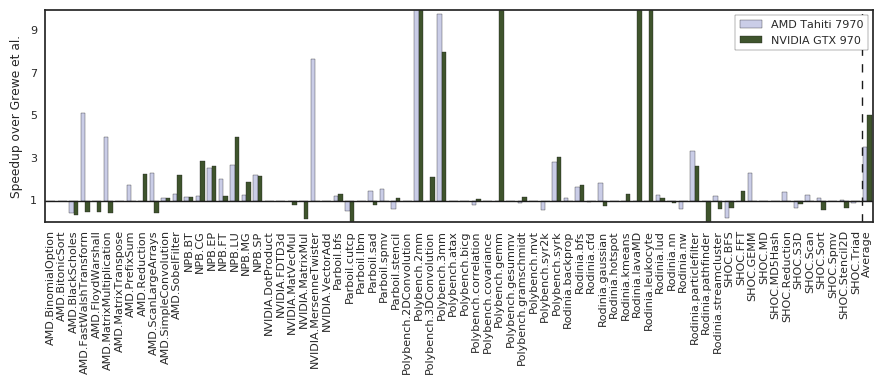

analyzing 13 amd-app-sdk-3.0-SobelFilter
  #. benchmarks:           17 kernels, 17 observations
  #. synthetic:            10 kernels, 138 observations

  Speedup:                 1.00 x


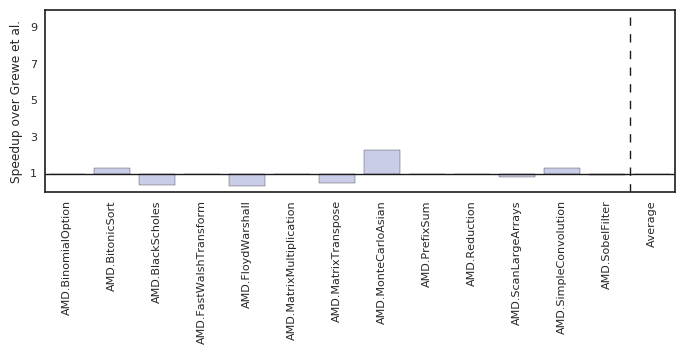

In [67]:
def compare_clfs(clf1, get_features1, clf2, get_features2, D1, D2, benchmark):
    """cross-validate across all benchmarks using CGO13 model and our own, with
    and without synthetic benchmarks. Report per-platform speedup of our model
    over CGO13"""
    test1_mask = D1["benchmark"].str.contains(r"^" + benchmark)
    test2_mask = D2["benchmark"].str.contains(r"^" + benchmark)
    assert(len(D1[test1_mask]) == len(D2[test2_mask]))

    # create data masks. For training we exclude all results from benchmark
    train1_mask = ~test1_mask
    train2_mask = ~test2_mask

    # create training and testing data
    X1_train = get_features1(D1.loc[train1_mask])
    X2_train = get_features2(D2.loc[train2_mask])
    y1_train = cgo13.getlabels(D1[train1_mask])
    y2_train = cgo13.getlabels(D2[train2_mask])

    D1_test = D1[test1_mask]
    D2_test = D2[test2_mask]
    X1_test = get_features1(D1.loc[test1_mask])
    X2_test = get_features2(D2.loc[test2_mask])
    y1_test = cgo13.getlabels(D1_test)
    y2_test = cgo13.getlabels(D2_test)

    clf1.fit(X1_train, y1_train)  # train classifiers
    clf2.fit(X2_train, y2_train)

    predicted1 = clf1.predict(X1_test)  # make predictions
    predicted2 = clf2.predict(X2_test)

    D_out = []
    for d, y, p1, p2 in zip(D1_test.to_dict('records'), y1_test,
                            predicted1, predicted2):
        d["p1"], d["p2"] = p1, p2
        D_out.append(d)

    return D_out  # return a list of dicts


aB = pd.read_csv("../data/amd-benchmarks.csv")
aB["synthetic"] = np.zeros(len(aB))
bB = pd.read_csv("../data/nvidia-benchmarks.csv")
bB["synthetic"] = np.zeros(len(bB))
B = pd.concat((aB, bB))

aS = pd.read_csv("../data/amd-clgen.csv")
aS["synthetic"] = np.ones(len(aS))
bS = pd.read_csv("../data/nvidia-clgen.csv")
bS["synthetic"] = np.ones(len(bS))
S = pd.concat((aS, bS))

aBS = pd.concat((aB, aS))
bBS = pd.concat((bB, bS))
BS = pd.concat((B, S))

assert(len(B) == len(aB) + len(bB))  # sanity checks
assert(len(S) == len(aS) + len(bS))
assert(len(BS) == len(aBS) + len(bBS))

# get benchmark names: <suite>-<benchmark>
benchmark_names = sorted(set([
    re.match(r"^([^0-9]+-[0-9\.]+-[^-]+)", b).group(1)
    for b in B["benchmark"]
]))

# perform cross-validation
B_out = []
for i, benchmark in enumerate(benchmark_names):
    print("\ranalyzing", i + 1, benchmark, end="")
    cgo13_clf, our_clf = cgo13.model(), get_our_model()
    cgo13_features, our_features = get_cgo13_features, get_our_features

    # cross validate on Grewe et al. and our model
    tmp = compare_clfs(cgo13_clf, cgo13_features, our_clf, our_features,
                       aBS, aBS, benchmark)
    for d in tmp: d["platform"] = "AMD Tahiti 7970"
    B_out += tmp

    # reset models
    cgo13_clf, our_clf = cgo13.model(), get_our_model()

    # same as before, on other platform:
    tmp = compare_clfs(cgo13_clf, cgo13_features, our_clf, our_features,
                       bBS, bBS, benchmark)
    for d in tmp: d["platform"] = "NVIDIA GTX 970"
    B_out += tmp
print()

# create results frame
R_out = []
# get runtimes of device using predicted device
for b in B_out:
    p1_runtime = b["runtime_" + b["p1"].lower()]
    p2_runtime = b["runtime_" + b["p2"].lower()]

    # speedup is the ratio of runtime using our predicted device
    # over runtime using CGO13 predicted device.
    b["p_speedup"] = p2_runtime / p1_runtime

    # get the benchmark name
    b["group"] = escape_benchmark_name(b["benchmark"])

    R_out.append(b)
R = pd.DataFrame(R_out)

improved = R[R["p_speedup"] > 1]

Amask = R["platform"] == "AMD Tahiti 7970"
Bmask = R["platform"] == "NVIDIA GTX 970"
a = R[Amask]
b = R[Bmask]

a_speedups = a.groupby(["group"])["p_speedup"].mean()
b_speedups = b.groupby(["group"])["p_speedup"].mean()

a_speedup = labmath.mean(a_speedups)
b_speedup = labmath.mean(b_speedups)

assert(len(R) == len(a) + len(b))  # sanity-check

header("Results from the paper")
print("  #. benchmarks:          ",
      len(set(B["benchmark"])), "kernels,", len(B), "observations")
print("  #. synthetic:           ",
      len(set(S["benchmark"])), "kernels,", len(S), "observations")
print()
print("  Speedup on AMD:          {:.2f} x".format(a_speedup))
print("  Speedup on NVIDIA:       {:.2f} x".format(b_speedup))

palette = sns.cubehelix_palette(
    len(set(R["platform"])), start=4, rot=.8, light=.8, dark=.3)

R = R.append({  # average bars
    "group": "Average",
    "p_speedup": a_speedup,
    "platform": "AMD Tahiti 7970"
}, ignore_index=True)
R = R.append({
    "group": "Average",
    "p_speedup": b_speedup,
    "platform": "NVIDIA GTX 970"
}, ignore_index=True)

R["p_speedup"] -= 1  # negative offset so that bars start at 1

ax = sns.barplot(x="group", y="p_speedup", hue="platform", data=R,
                 palette=palette, ci=None)

plt.ylabel("Speedup over Grewe et al."); plt.xlabel("")

plt.axhline(y=0, color="k", lw=1)
plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")
plt.ylim(-1, 9)
plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
ax.get_legend().set_title("")  # legend
plt.legend(loc='upper right')

# counter negative offset
ax.set_yticklabels([int(i) + 1 for i in ax.get_yticks()])

ax.get_legend().draw_frame(True)

viz.finalise(figsize=(9, 4), tight=True)

B = pd.read_csv("../data/benchmarks/training.csv")
B["synthetic"] = np.zeros(len(B))

S = pd.read_csv("../data/clgen-10/training.csv")
S["synthetic"] = np.ones(len(S))

BS = pd.concat((B, S))

assert(len(BS) == len(B) + len(S))

# get benchmark names: <suite>-<benchmark>
benchmark_names = sorted(set([
    re.match(r"^([^0-9]+-[0-9\.]+-[^-]+)", b).group(1)
    for b in B["benchmark"]
]))

# perform cross-validation
B_out = []
for i, benchmark in enumerate(benchmark_names):
    print("\ranalyzing", i + 1, benchmark, end="")
    cgo13_clf, our_clf = cgo13.model(), get_our_model()
    cgo13_features, our_features = get_cgo13_features, get_our_features

    # cross validate on Grewe et al. and our model
    tmp = compare_clfs(cgo13_clf, cgo13_features, our_clf, our_features,
                       BS, BS, benchmark)
    B_out += tmp
print()

# create results frame
R_out = []
# get runtimes of device using predicted device
for b in B_out:
    p1_runtime = b["runtime_" + b["p1"].lower()]
    p2_runtime = b["runtime_" + b["p2"].lower()]

    # speedup is the ratio of runtime using our predicted device
    # over runtime using CGO13 predicted device.
    b["p_speedup"] = p2_runtime / p1_runtime

    # get the benchmark name
    b["group"] = escape_benchmark_name(b["benchmark"])

    R_out.append(b)
R = pd.DataFrame(R_out)

improved = R[R["p_speedup"] > 1]

speedups = R.groupby(["group"])["p_speedup"].mean()
speedup = labmath.mean(speedups)

print("  #. benchmarks:          ",
      len(set(B["benchmark"])), "kernels,", len(B), "observations")
print("  #. synthetic:           ",
      len(set(S["benchmark"])), "kernels,", len(S), "observations")
print()
print("  Speedup:                 {:.2f} x".format(speedup))

palette = sns.cubehelix_palette(1, start=4, rot=.8, light=.8, dark=.3)

R = R.append({  # average bar
    "group": "Average",
    "p_speedup": speedup
}, ignore_index=True)

R["p_speedup"] -= 1  # negative offset so that bars start at 1

ax = sns.barplot(x="group", y="p_speedup", data=R,
                 palette=palette, ci=None)

plt.ylabel("Speedup over Grewe et al."); plt.xlabel("")

plt.axhline(y=0, color="k", lw=1)
plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")
plt.ylim(-1, 9)
plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks

# counter negative offset
ax.set_yticklabels([int(i) + 1 for i in ax.get_yticks()])

viz.finalise(figsize=(7, 3.7), tight=True)
complete(speedup >= 1, "Extended model improves performance")

This is the end of the Artifact Evaluation experiments. For a much more comprehensive evaluation of our work, including all of the steps necessary to reproduce every Figure figure in the paper, click this link:
# [Interactive Paper](/notebooks/Paper.ipynb)